In [1]:
commonnamedict = {'9606': 'Human', '9598': 'Chimp', '9544': 'Rhesus', '9615': 'Dog', '9913': 'Cow', '10090': 'Mouse', '10116': 'Rat', '13616': 'Marsupial', '9031': 'Chicken', '8364': 'Frog'}
namedict = {'9606': 'Homo_sapiens', '9598': 'Pan_paniscus', '9544': 'Macaca_mulatta', '9615': 'Canis_lupus_familiaris', '9913': 'Bos_taurus', '10090': 'Mus_musculus', '10116': 'Rattus_norvegicus', '13616': 'Monodelphis_domestica', '9031': 'Gallus_gallus', '8364': 'Xenopus_tropicalis'}

latin2common = {}
for taxid, latin in namedict.items():
    common = commonnamedict[taxid]
    latin2common[latin] = common


### eightmer - gains
human - Gold
mouse - SteelBlue
both - ForestGreen

Homo_sapiens 3
Macaca_mulatta 0
1 3
Mus_musculus 4
Rattus_norvegicus 1
2 7
3 1
Bos_taurus 1
Canis_lupus_familiaris 3
4 0
5 2
Monodelphis_domestica 3
6 2
Gallus_gallus 0
7 2
Xenopus_tropicalis 0


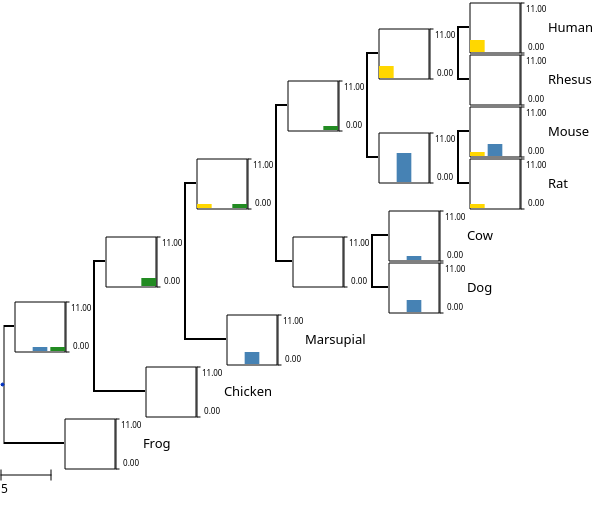

In [2]:
import pandas as pd
from ete3 import Tree, NodeStyle, TreeStyle, PieChartFace, TextFace, BarChartFace

##################################################################################################################################################################
treepath = '../data/noChimp_contextscore_reordered.tree'
#testdollo = '../data/dolloMatrices/tsH/sixmer/sixmer_tarPredictedFor_both_Mir-197-3p_by_tsH.dollo'
testdollo = '../data/dolloMatrices/tsH/eightmer/eightmer_tarPredictedFor_both_Mir-197-3p_by_tsH.dollo'


dollopaths = {
    'sixmer': 
    {
        'human': '../data/dolloMatrices/Mir-197-3p/tsH/sixmer/sixmer_tarPredictedFor_human_Mir-197-3p_by_tsH.dollo', 
        'mouse': '../data/dolloMatrices/Mir-197-3p/tsH/sixmer/sixmer_tarPredictedFor_mouse_Mir-197-3p_by_tsH.dollo',
        'both': '../data/dolloMatrices/Mir-197-3p/tsH/sixmer/sixmer_tarPredictedFor_both_Mir-197-3p_by_tsH.dollo'
    },
    'eightmer': 
    {
        'human': '../data/dolloMatrices/Mir-197-3p/tsH/eightmer/eightmer_tarPredictedFor_human_Mir-197-3p_by_tsH.dollo',
        'mouse': '../data/dolloMatrices/Mir-197-3p/tsH/eightmer/eightmer_tarPredictedFor_mouse_Mir-197-3p_by_tsH.dollo',
        'both': '../data/dolloMatrices/Mir-197-3p/tsH/eightmer/eightmer_tarPredictedFor_both_Mir-197-3p_by_tsH.dollo'
    }
    #'sevenmer':
    #{
    #    'human': '../data/dolloMatrices/Mir-197-3p/tsH/sevenmer/sevenmer_tarPredictedFor_human_Mir-197-3p_by_tsH.dollo',
    #    'mouse': '../data/dolloMatrices/Mir-197-3p/tsH/sevenmer/sevenmer_tarPredictedFor_mouse_Mir-197-3p_by_tsH.dollo',
    #    'both': '../data/dolloMatrices/Mir-197-3p/tsH/sevenmer/sevenmer_tarPredictedFor_both_Mir-197-3p_by_tsH.dollo'
    #}
}

##################################################################################################################################################################
    
def parse_dollo(dollop, treep):
    """
    Read Dollo matrix from Count and corresponding Treefile. Annotate all nodes in tree with
    
    'gains':      Number of inferred gains at node
    'losses':     Number of inferred losses at node
    'famlist':    Set of family names present at node
    'support':    Number of families present at node (Hijacks the Bootstrap-support property for easier display when visualizing
    """
    
    def read_dollo(path):
        od = {}
        df = pd.read_csv(path, skiprows=1, sep='\t', index_col=0)
        df[df != 0] = 1  # disregard gene copies, count families only

        for node in df.columns:
            families = set(df[df[node] > 0].index)
            od[node.replace(' ', '_')] = families
        return od


    def annotate_nodes(tree, dollo):
        intercount = 1
        for node in tree.iter_descendants("postorder"): 
            if not node.is_leaf():
                node.name = str(intercount)
                intercount += 1
            node.add_features(famlist=dollo[node.name])
        return tree


    def gain_and_loss(tree):
        for node in tree.iter_descendants("postorder"): 
            if node.up.is_root():
                parent_fams = set()
            else:
                parent_fams = node.up.famlist
            l =  len(parent_fams - node.famlist)
            g = len(node.famlist - parent_fams)
            node.add_features(gains=g, losses=l)
        return tree
    
    ### main
    doldict = read_dollo(dollop)
    t = Tree(treepath, format=1)
    t = annotate_nodes(t, doldict)
    t = gain_and_loss(t)
    for node in t.iter_descendants("postorder"): 
        node.dist = 1
        node.support = len(node.famlist)
    
    return t


def pie_nodes(t, valuedict, kmer, event):
    tn = t.copy()
    tn.convert_to_ultrametric()
    print(f'### {kmer} - {event}')
    ts = TreeStyle()
    ts.min_leaf_separation = 20
    ts.show_leaf_name = False
    ts.branch_vertical_margin = -2
    ts.scale =  10
    cols = ['Gold', 'SteelBlue', 'ForestGreen']
    for i, targetstyle in enumerate(collect[kmer]['Homo_sapiens']):
        print(f'{targetstyle} - {cols[i]}')
    print()
    
    for node in tn.iter_descendants("postorder"):
        nstyle = NodeStyle()
        nstyle["size"] = 0
        nstyle["vt_line_width"] = 2
        nstyle["hz_line_width"] = 2

        
        if node.is_leaf():
            common = latin2common[node.name]
            node.add_face(TextFace(common, ftype='sans'), column=1)
        
        
        total_pie = 0
        for targetstyle in collect[kmer][node.name]:
            total_pie += collect[kmer][node.name][targetstyle][event]

        if total_pie > 0:
            percentagelist = []
            for targetstyle in collect[kmer][node.name]:
                value = collect[kmer][node.name][targetstyle][event]
                percentagelist.append((value / total_pie) * 100)

            multip = 8
            N = PieChartFace(percentagelist, width=total_pie*multip, height=total_pie*multip, colors=cols)
            #N = BarChartFace([node.gains, node.losses], max_value=3)
            node.add_face(N, 0)
            
        node.set_style(nstyle)
    return tn, ts

def bar_nodes(t, collect, kmer, event):
    tn = t.copy()
    tn.convert_to_ultrametric()
    print(f'### {kmer} - {event}')
    ts = TreeStyle()
    ts.min_leaf_separation = 20
    ts.show_leaf_name = False
    ts.branch_vertical_margin = -2
    ts.scale =  10
    cols = ['Gold', 'SteelBlue', 'ForestGreen']
    for i, targetstyle in enumerate(collect[kmer]['Homo_sapiens']):
        print(f'{targetstyle} - {cols[i]}')
    print()

    max_events = 0
    for node in tn.iter_descendants("postorder"):
        barlist = [collect[kmer][node.name][targetstyle][event] for targetstyle in collect[kmer][node.name]]
        print(node.name, sum(barlist))
        if sum(barlist) > max_events:
            max_events = sum(barlist)
    
    for node in tn.iter_descendants("postorder"):
        nstyle = NodeStyle()
        nstyle["size"] = 0
        nstyle["vt_line_width"] = 2
        nstyle["hz_line_width"] = 2

        
        if node.is_leaf():
            common = latin2common[node.name]
            node.add_face(TextFace(common, ftype='sans'), column=1)
        
        barlist = [collect[kmer][node.name][targetstyle][event] for targetstyle in collect[kmer][node.name]]
        # if sum(barlist) > 0:
        N = BarChartFace(barlist, colors=cols, max_value=11, width=50, height=50)
        node.add_face(N, 0)
            
        node.set_style(nstyle)
    return tn, ts


    
##################################################################################################################################################################

collect = {}
"""
{'kmer': 'node': {{'targetfor': {'losses': int, 'gains': int}}}}
"""
for kmer in dollopaths:
    collect[kmer] = {}
    for targetfor, path in dollopaths[kmer].items():
        tree = parse_dollo(path, treepath)
        for node in tree.iter_descendants("postorder"):
            if not node.name in collect[kmer]:
                collect[kmer][node.name] = {}
            collect[kmer][node.name][targetfor] = {'losses': node.losses, 'gains': node.gains} 
            
            
pietree, pielayout = bar_nodes(tree, collect, 'eightmer', 'gains')
pietree.render("%%inline", tree_style=pielayout)

### sixmer - gains
human - Gold
mouse - SteelBlue
both - ForestGreen

Homo_sapiens 9
Macaca_mulatta 11
1 9
Mus_musculus 9
Rattus_norvegicus 17
2 3
3 0
Bos_taurus 11
Canis_lupus_familiaris 7
4 0
5 10
Monodelphis_domestica 10
6 2
Gallus_gallus 4
7 0
Xenopus_tropicalis 5


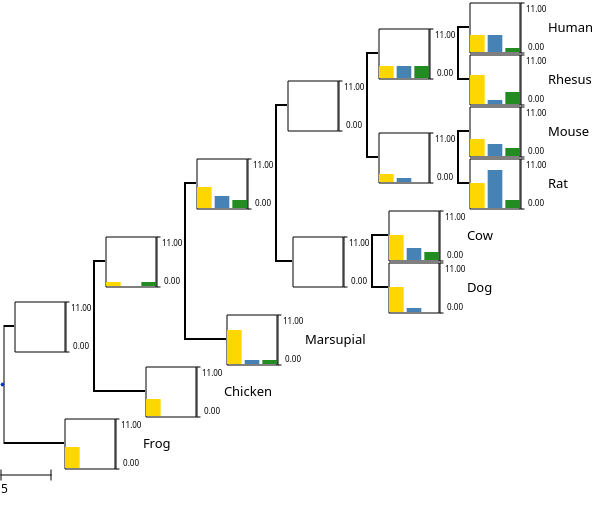

In [4]:
pietree, pielayout = bar_nodes(tree, collect, 'sixmer', 'gains')
pietree.render("%%inline", tree_style=pielayout)